In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import cftime
import cartopy.crs as ccrs
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib.colors import BoundaryNorm
import matplotlib.cm as cm


# Prices

In [ ]:
fsv1 = pd.read_excel('..data/fsv prices.xlsx', sheet_name='1508-1785')
#add _fsv1 to column names
fsv1.rename(columns={"Market" : "Year"}, inplace=True)

#fsv1 = fsv1.drop(columns=['Unnamed: 16', 'Number','CV','Average', 'SD'])
fsv1 = fsv1.drop(columns=['Unnamed: 32', 'Number'])
fsv1 = fsv1.loc[(fsv1['Year'] >= 1500) & (fsv1['Year'] <= 1800)]

fsv1 = fsv1.set_index('Year')

#fsv1 = (fsv1 - fsv1.mean()) / fsv1.std()
print(fsv1.columns)

Index(['Albi', 'Arezzo', 'Augsburg', 'Barcelona', 'Bruges', 'Brunswick',
       'Brussels', 'Cambridge', 'Cologne', 'Cremona', 'Douai', 'Exeter',
       'Grenoble', 'Leiden', 'Liège', 'Limoges', 'London', 'Mallorca', 'Milan',
       'Münster', 'Nuremberg', 'Padua', 'Paris', 'Pisa', 'Strasbourg',
       'Toulouse', 'Udine', 'Utrecht', 'Valencia', 'Wels', 'Xanten'],
      dtype='object')


array([[<Axes: xlabel='Year'>, <Axes: xlabel='Year'>,
        <Axes: xlabel='Year'>, <Axes: xlabel='Year'>,
        <Axes: xlabel='Year'>],
       [<Axes: xlabel='Year'>, <Axes: xlabel='Year'>,
        <Axes: xlabel='Year'>, <Axes: xlabel='Year'>,
        <Axes: xlabel='Year'>],
       [<Axes: xlabel='Year'>, <Axes: xlabel='Year'>,
        <Axes: xlabel='Year'>, <Axes: xlabel='Year'>,
        <Axes: xlabel='Year'>],
       [<Axes: xlabel='Year'>, <Axes: xlabel='Year'>,
        <Axes: xlabel='Year'>, <Axes: xlabel='Year'>,
        <Axes: xlabel='Year'>],
       [<Axes: xlabel='Year'>, <Axes: xlabel='Year'>,
        <Axes: xlabel='Year'>, <Axes: xlabel='Year'>,
        <Axes: xlabel='Year'>],
       [<Axes: xlabel='Year'>, <Axes: xlabel='Year'>,
        <Axes: xlabel='Year'>, <Axes: xlabel='Year'>,
        <Axes: xlabel='Year'>],
       [<Axes: xlabel='Year'>, <Axes: xlabel='Year'>,
        <Axes: xlabel='Year'>, <Axes: xlabel='Year'>,
        <Axes: xlabel='Year'>],
       [<Axes: xlabe

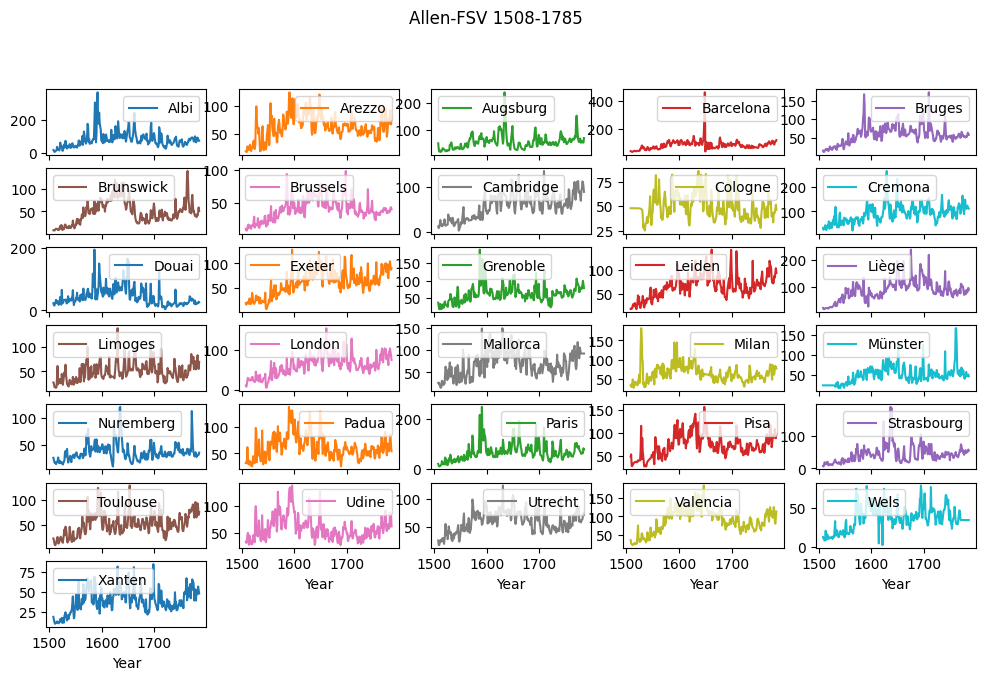

In [9]:
prices = fsv1.copy()

start = prices.index.min()
end = prices.index.max()
prices.plot(figsize=(12, 8), title=f'Allen-FSV {start}-{end}',subplots=True, layout=(8, 5), sharex=True)

In [10]:
from geopy.geocoders import Nominatim
import time

cities = prices.columns.tolist()

geolocator = Nominatim(user_agent="city_geocoder")

city_to_coords = {}

for city in cities:
    try:
        location = geolocator.geocode(city)
        if location:
            city_to_coords[city] = (location.latitude, location.longitude)
            print(f"{city}: ({location.latitude}, {location.longitude})")
        else:
            print(f"{city}: Not found")
    except Exception as e:
        print(f"Error with {city}: {e}")
    time.sleep(1)  # To avoid getting blocked by the server



Albi: (43.9277552, 2.147899)
Arezzo: (43.5171442, 11.7639282)
Augsburg: (48.3690341, 10.8979522)
Barcelona: (41.3825802, 2.177073)
Bruges: (51.2085526, 3.226772)
Brunswick: (52.2646577, 10.5236066)
Brussels: (50.8465573, 4.351697)
Cambridge: (52.2055314, 0.1186637)
Cologne: (50.938361, 6.959974)
Cremona: (45.2208641, 10.037038)
Douai: (50.3675677, 3.0804641)
Exeter: (50.7256138, -3.5269209)
Grenoble: (45.1875602, 5.7357819)
Leiden: (52.1594747, 4.4908843)
Liège: (50.6450944, 5.5736112)
Limoges: (45.8354243, 1.2644847)
London: (51.5074456, -0.1277653)
Mallorca: (39.613432, 2.8829185)
Milan: (45.4641943, 9.1896346)
Münster: (51.9625101, 7.6251879)
Nuremberg: (49.453872, 11.077298)
Padua: (45.4077172, 11.8734455)
Paris: (48.8534951, 2.3483915)
Pisa: (43.4714722, 10.6797912)
Strasbourg: (48.584614, 7.7507127)
Toulouse: (43.6044622, 1.4442469)
Udine: (46.0634632, 13.2358377)
Utrecht: (52.0907006, 5.1215634)
Valencia: (39.4697065, -0.3763353)
Wels: (52.2928116, -3.73893)
Xanten: (51.661519, 

# PDSI

In [ ]:
# Load OWDA and compute weighted PDSI
owda = xr.open_dataset("..data/owda.nc")
owda["PDSI_weighted"] = np.sqrt(np.cos(np.deg2rad(owda["lat"])) + 1e-6) * owda["pdsi"]

# Flatten the 3D (time, lat, lon) data into a long table of gridpoints
pdsi_grid = owda["PDSI_weighted"].stack(points=("lat", "lon")).reset_coords()

# Drop points where all values are NaN
valid_points = pdsi_grid.dropna(dim="points", how="all")

# Extract coordinates for KDTree
grid_coords = np.column_stack([valid_points["lat"].values, valid_points["lon"].values])
tree = cKDTree(grid_coords)

# Prepare city coordinates
city_coords = np.array(list(city_to_coords.values()))  # shape (n_cities, 2)

# Find nearest grid point for each city
distances, indices = tree.query(city_coords, k=1, workers = -1)

# For each city, extract the time series from the nearest grid point
selected_data = []
years = owda["time"].values

for i, (city, coord) in enumerate(city_to_coords.items()):
    grid_idx = indices[i]
    lat = valid_points["lat"].values[grid_idx]
    lon = valid_points["lon"].values[grid_idx]

    # Get the PDSI series from that grid point
    city_ts = owda["PDSI_weighted"].sel(lat=lat, lon=lon, method="nearest")
    city_ts = city_ts.assign_coords(Location=city)
    selected_data.append(city_ts)

# Combine the city time series (DataArrays) into a Dataset
pdsi_selected = xr.Dataset({
    'PDSI': xr.concat(selected_data, dim="loc_id")
})

# Rename time to Year
pdsi_selected = pdsi_selected.rename({"time": "Year"})

# Add domain averages as DataArrays (with the same time/Year dimension)
pdsi_selected["PDSI_europe"] = owda["PDSI_weighted"].sel(lat=slice(35, 70), lon=slice(-10, 40)).mean(dim=["lat", "lon"]).rename({"time": "Year"})
pdsi_selected["PDSI_southern"] = owda["PDSI_weighted"].sel(lat=slice(20, 40), lon=slice(-10, 20)).mean(dim=["lat", "lon"]).rename({"time": "Year"})

pdsi_df = pdsi_selected.to_dataframe().reset_index()
pdsi_df.rename(columns={"PDSI_weighted": "PDSI"}, inplace=True)

## Temp

In [ ]:
# Load dataset
xds = xr.open_dataset('..data/ModE-RA_ensmean_temp2_anom_wrt_1901-2000_1421-2008_mon.nc')

# Extract year and filter by given range
xds = xds.assign(Year=xds.time.dt.year)
xds = xds.sel(time=slice(str(1500), str(1800)))

# Apply latitude weighting
xds['temp'] = np.sqrt(np.cos(np.deg2rad(xds['latitude'])) + 1e-6) * (xds['temp2'])

winter_months = [11, 12, 1, 2]
summer_months = [4, 5, 6, 7]

def shift_decembers(time_array):
    return [cftime.DatetimeGregorian(t.year + 1, t.month, t.day) if t.month in [11, 12] else t for t in time_array]

xds = xds.assign_coords(time=("time", shift_decembers(xds.time.values)))



# --- **(1) Compute City-Level Temperatures** ---
def extract_location_data(xds_season):
    return [
        xds_season.sel(latitude=lat, longitude=lon, method='nearest')
        .to_dataframe().reset_index().assign(Location=city)
        for city, (lat, lon) in city_to_coords.items()
    ]

# Compute city-level seasonal means
xds_winter_cities = xds.sel(time=xds.time.dt.month.isin(winter_months)).groupby('Year').mean(dim='time')
xds_summer_cities = xds.sel(time=xds.time.dt.month.isin(summer_months)).groupby('Year').mean(dim='time')

temp_winter = pd.concat(extract_location_data(xds_winter_cities), ignore_index=True)
temp_summer = pd.concat(extract_location_data(xds_summer_cities), ignore_index=True)

# --- **(2) Compute European Domain-Average Temperatures** ---
# Define European bounding box (adjust as needed)
lat_bounds = (70, 35)   # Latitude range for Europe
lon_bounds = (-15, 35)  # Longitude range for Europe

# Subset dataset to Europe only
xds_europe = xds.sel(latitude=slice(*lat_bounds), longitude=slice(*lon_bounds))

# Function to compute spatially averaged seasonal mean
def compute_seasonal_mean(xds, months):
    return (xds.sel(time=xds.time.dt.month.isin(months))
            .groupby('Year').mean(dim='time')
            .mean(dim=['latitude', 'longitude']))

# Compute European domain-average temperatures
xds_winter_europe = compute_seasonal_mean(xds_europe, winter_months)
xds_summer_europe = compute_seasonal_mean(xds_europe, summer_months)

# Convert to DataFrame
europe_temp_df = pd.DataFrame({
    'Year': xds_winter_europe.Year.values,
    'temp_winter_europe': xds_winter_europe['temp'].values,
    'temp_summer_europe': xds_summer_europe['temp'].values
})

# --- **(3) Merge Everything Together** ---
temp_df = pd.merge(temp_winter, temp_summer, on=['Year', 'Location'], suffixes=('_winter', '_summer'))

# Drop unnecessary columns
temp_df = temp_df.drop(columns=['latitude_winter', 'longitude_winter', 'latitude_summer', 'longitude_summer', 'temp2_winter', 'temp2_summer'])

# Merge with European averages
temp_df = pd.merge(temp_df, europe_temp_df, on='Year', how='left')




C:\Users\emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\coding\times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\indexing.py:516: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


# PRecip

In [ ]:
# Load dataset
xds_p = xr.open_dataset('..data/ModE-RA_ensmean_totprec_anom_wrt_1901-2000_1421-2008_mon.nc')

# Extract year and filter by given range
xds_p = xds_p.assign(Year=xds_p.time.dt.year)
xds_p = xds_p.sel(time=slice(str(1500), str(1800)))

# Apply latitude weighting
xds_p['precip'] = np.sqrt(np.cos(np.deg2rad(xds_p['latitude'])) + 1e-6) * xds_p['totprec']*86400*30

# Define seasons
winter_months = [11, 12, 1, 2]
summer_months = [4, 5, 6, 7]

def shift_decembers(time_array):
    return [cftime.DatetimeGregorian(t.year + 1, t.month, t.day) if t.month in [11, 12] else t for t in time_array]

xds_p = xds_p.assign_coords(time=("time", shift_decembers(xds_p.time.values)))



# --- **(1) Compute City-Level preciperatures** ---
def extract_location_data(xds_p_season):
    return [
        xds_p_season.sel(latitude=lat, longitude=lon, method='nearest')
        .to_dataframe().reset_index().assign(Location=city)
        for city, (lat, lon) in city_to_coords.items()
    ]

# Compute city-level seasonal means
xds_p_winter_cities = xds_p.sel(time=xds_p.time.dt.month.isin(winter_months)).groupby('Year').mean(dim='time')
xds_p_summer_cities = xds_p.sel(time=xds_p.time.dt.month.isin(summer_months)).groupby('Year').mean(dim='time')

precip_winter = pd.concat(extract_location_data(xds_p_winter_cities), ignore_index=True)
precip_summer = pd.concat(extract_location_data(xds_p_summer_cities), ignore_index=True)

# --- **(2) Compute European Domain-Average preciperatures** ---
# Define European bounding box (adjust as needed)
lat_bounds = (70, 35)   # Latitude range for Europe
lon_bounds = (-15, 35)  # Longitude range for Europe

# Subset dataset to Europe only
xds_p_europe = xds_p.sel(latitude=slice(*lat_bounds), longitude=slice(*lon_bounds))

# Function to compute spatially averaged seasonal mean
def compute_seasonal_mean(xds_p, months):
    return (xds_p.sel(time=xds_p.time.dt.month.isin(months))
            .groupby('Year').mean(dim='time')
            .mean(dim=['latitude', 'longitude']))

# Compute European domain-average preciperatures
xds_p_winter_europe = compute_seasonal_mean(xds_p_europe, winter_months)
xds_p_summer_europe = compute_seasonal_mean(xds_p_europe, summer_months)

# Convert to DataFrame
europe_precip_df = pd.DataFrame({
    'Year': xds_p_winter_europe.Year.values,
    'precip_winter_europe': xds_p_winter_europe['precip'].values,
    'precip_summer_europe': xds_p_summer_europe['precip'].values
})

# --- **(3) Merge Everything Together** ---
precip_df = pd.merge(precip_winter, precip_summer, on=['Year', 'Location'], suffixes=('_winter', '_summer'))

# Drop unnecessary columns
precip_df = precip_df.drop(columns=['latitude_winter', 'longitude_winter', 'latitude_summer', 'longitude_summer', 'totprec_winter', 'totprec_summer'])

# Merge with European averages
precip_df = pd.merge(precip_df, europe_precip_df, on='Year', how='left')


C:\Users\emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\coding\times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\indexing.py:516: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


In [14]:
precip_df

,Year,precip_winter,Location,precip_summer,precip_winter_europe,precip_summer_europe
0,1500,6.293899,Albi,5.430660,3.701608,1.530405
1,1501,7.383236,Albi,-0.490139,6.950090,2.234130
2,1502,9.963288,Albi,-4.310192,5.003024,1.973519
3,1503,10.399484,Albi,12.962616,3.932595,3.473891
4,1504,14.124101,Albi,11.453354,7.394137,3.469000
...,...,...,...,...,...,...
9326,1796,-7.476486,Xanten,-8.794571,3.547078,2.296583
9327,1797,-6.668009,Xanten,2.506790,-0.532314,3.073820
9328,1798,-4.030005,Xanten,-14.926384,2.492704,0.716590
9329,1799,-5.145996,Xanten,-1.719888,-0.069864,4.915635


# ENSO

In [ ]:
# Read the file while skipping the metadata (commented lines)
enso1 = pd.read_csv("..data/enso-li2011-noaa.txt", delimiter="\t", comment="#", na_values="NA")

enso2 = pd.read_csv("..data/enso-li2013.txt", delimiter="\t", comment="#", na_values="NA")

enso1 = enso1.rename(columns={"ensoi": "enso1", "age": "Year"})
enso2 = enso2.rename(columns={"sst.anom": "enso2", "age_AD": "Year"})


In [ ]:
enso3 = pd.read_csv("..data/cook2024-R15-ENSO-Rec-1500-2000.txt", delimiter="\t", comment="#", na_values="NA")
lat_lon = pd.read_csv("..data/cook2024-ENSO-latlon.txt", delimiter="\t", comment="#", na_values="NA")

In [17]:
# Melt the ENSO DataFrame to long format
enso_melted = enso3.melt(id_vars=["Year"], var_name="gridpoint", value_name="enso")
enso_melted["gridpoint"] = enso_melted["gridpoint"].astype(int)

# Merge with the lat/lon DataFrame
enso_merged = enso_melted.merge(lat_lon, on="gridpoint")



# Convert to xarray
enso_xr = enso_merged.set_index(["Year", "lat", "lon"])["enso"].to_xarray()

enso_xr = enso_xr  - enso_xr.sel(Year=slice(1801, 1900)).mean(dim="Year")

nino3 = enso_xr.sel(lat=slice(-5, 5), lon=slice(-150, -90)).mean(dim=["lat", "lon"])
nino34 = enso_xr.sel(lat=slice(-5, 5), lon=slice(-170, -120)).mean(dim=["lat", "lon"])
nino4 = enso_xr.sel(lat=slice(-5, 5), lon = slice(-200, -150)).mean(dim=["lat", "lon"])
nino12 = enso_xr.sel(lat=slice(-10, 0), lon=slice(-90, -80)).mean(dim=["lat", "lon"])

In [18]:
enso = pd.merge(enso1, enso2, on="Year")
enso = pd.merge(enso, nino3.to_dataframe().reset_index().rename(columns={"enso": "nino3"}), on="Year")
enso = pd.merge(enso, nino34.to_dataframe().reset_index().rename(columns={"enso": "nino34"}), on="Year")
enso = pd.merge(enso, nino4.to_dataframe().reset_index().rename(columns={"enso": "nino4"}), on="Year")
enso = pd.merge(enso, nino12.to_dataframe().reset_index().rename(columns={"enso": "nino12"}), on="Year")


<Axes: xlabel='Year'>

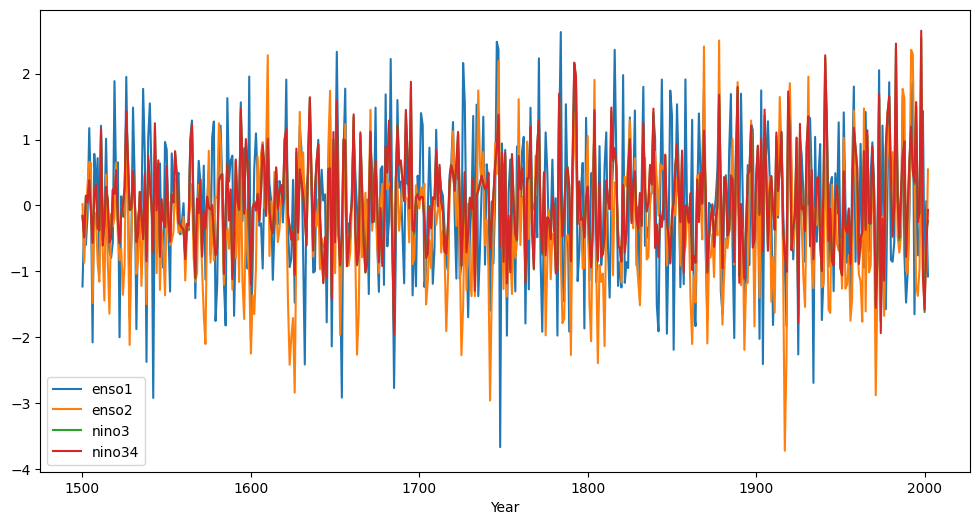

In [19]:
enso.plot(x="Year", y=["enso1", "enso2", "nino3", "nino34"], figsize=(12, 6))

In [20]:
#compute correlation of enso
enso.corr()

,Year,enso1,ensovar,enso2,nino3,nino34,nino4,nino12
Year,1.000000,0.004089,0.361381,0.036862,0.041231,0.040809,0.045482,0.045678
enso1,0.004089,1.000000,-0.019638,0.455751,0.554309,0.551676,0.548017,0.552382
ensovar,0.361381,-0.019638,1.000000,0.023715,0.072925,0.072270,0.075518,0.079025
enso2,0.036862,0.455751,0.023715,1.000000,0.679123,0.677075,0.674991,0.675936
nino3,0.041231,0.554309,0.072925,0.679123,1.000000,0.998815,0.995912,0.991058
nino34,0.040809,0.551676,0.072270,0.677075,0.998815,1.000000,0.998054,0.985124
nino4,0.045482,0.548017,0.075518,0.674991,0.995912,0.998054,1.000000,0.985398
nino12,0.045678,0.552382,0.079025,0.675936,0.991058,0.985124,0.985398,1.000000


# JSL and NAO

In [ ]:
jsl = pd.read_excel("..data/reconstructed EU JSL.xlsx")

nao_cal = pd.read_excel("..data/nao_reconst.xlsx", sheet_name="Figure 2a", header=3)
nao_cal = nao_cal.rename(columns={"Time (years AD)" : "Year"})
nao_model = pd.read_excel("..data/nao_reconst.xlsx", sheet_name="Figure 2b", header=3)
nao_model = nao_model.rename(columns={"Time (years AD)" : "Year"})

nao = pd.merge(nao_cal, nao_model, on="Year", suffixes=('_cal', '_model'))

nao = nao.rename(columns={"Ensemble Mean_cal" : "NAO_cal", "Ensemble Mean_model" : "NAO_model"})[["Year", "NAO_cal", "NAO_model"]]

C:\Users\emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


# COnflict

C:\Users\emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


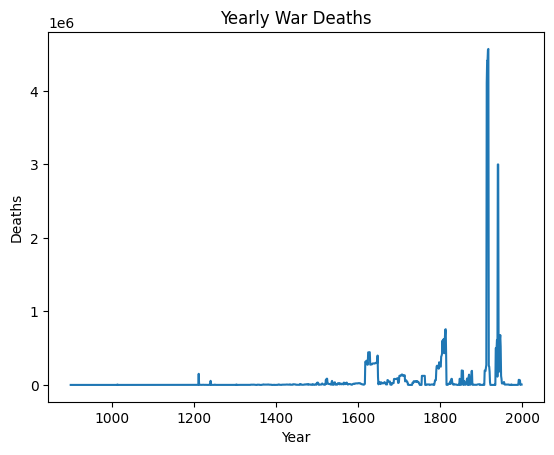

In [ ]:
# Load the data
post1400 = pd.read_excel('..data/Conflict-Catalog-18-vars.xlsx')
pre1400 = pd.read_excel('..data/Brecke-Pre-1400-European-Conflicts.xlsx')


# Convert StartYear and EndYear to integer if not NaN
post1400['StartYear'] = post1400['StartYear'].apply(lambda x: int(x) if not pd.isna(x) else np.nan)
post1400['EndYear'] = post1400['EndYear'].apply(lambda x: int(x) if not pd.isna(x) else np.nan)

# Filter Region to be 3 and 4
post1400 = post1400[post1400['Region'].isin([3, 4])]
# Select relevant columns
post1400 = post1400[['TotalFatalities', 'MilFatalities', 'StartYear', 'EndYear']].copy()
pre1400 = pre1400[['Fatalities', 'StartYear', 'EndYear']].copy()

# Fill NaN values in TotalFatalities and MilFatalities with 0
post1400['TotalFatalities'] = post1400['TotalFatalities'].fillna(0)
post1400['MilFatalities'] = post1400['MilFatalities'].fillna(0)
post1400['Deaths'] = post1400['TotalFatalities']

pre1400['Deaths'] = pre1400['Fatalities'].fillna(0)

# Drop TotalFatalities and MilFatalities
post1400 = post1400.drop(columns=['TotalFatalities', 'MilFatalities'])

pre1400 = pre1400.drop(columns=['Fatalities'])

wars = pd.concat([pre1400,post1400])

# Initialize an empty dictionary for tracking deaths per year
death_index = {}

# Populate the index with death counts, ongoing wars, started wars, and total duration
for _, row in wars.iterrows():
    if pd.isna(row['StartYear']) or pd.isna(row['EndYear']):
        continue
    
    year_range = range(int(row['StartYear']), int(row['EndYear']) + 1)
    deaths_per_year = row['Deaths'] / len(year_range)
    duration = len(year_range)
    
    for year in year_range:
        if year in death_index:
            death_index[year]['Deaths'] += deaths_per_year
            death_index[year]['ongoing_wars'] += 1
            if year == row['StartYear']:
                death_index[year]['started_wars'] += 1
                death_index[year]['total_duration'] += duration
        else:
            death_index[year] = {
                'Deaths': deaths_per_year,
                'ongoing_wars': 1,
                'started_wars': 1 if year == row['StartYear'] else 0,
                'total_duration': duration if year == row['StartYear'] else 0
            }

# Convert dictionary to DataFrame
conflict = pd.DataFrame.from_dict(death_index, orient='index').reset_index()

conflict['Death_ratio'] = conflict['Deaths'] / conflict['ongoing_wars']
conflict.rename(columns={'index': 'Year'}, inplace=True)
conflict = conflict.sort_values(by='Year').reset_index(drop=True).fillna(0)

conflict.set_index('Year')['Deaths'].plot()
plt.xlabel('Year')
plt.ylabel('Deaths')
plt.title('Yearly War Deaths')
plt.show()


# Merge everyone and save

In [23]:
df_total = pd.merge(temp_df, pdsi_df, on=['Year', 'Location']) 
df_total = pd.merge(df_total, precip_df, on=['Year', 'Location'])
df_total = pd.merge(df_total, enso, on=['Year'])
df_total = pd.merge(df_total, jsl, on=['Year'])
df_total = pd.merge(df_total, nao, on=['Year'])
prices['Year'] = prices.index
prices_long = prices.melt(id_vars=['Year'], var_name='Location', value_name='price')
df_total = pd.merge(df_total, prices_long, on=['Year', 'Location'])
df_total = df_total.sort_values(['Location', 'Year'])

df_total = pd.merge(df_total, conflict, on=['Year'], how='left')
df_total[['Deaths', 'ongoing_wars', 'started_wars', 'total_duration', 'Death_ratio']] = df_total[['Deaths', 'ongoing_wars', 'started_wars', 'total_duration', 'Death_ratio']].fillna(0)

# add coords to df_total
for city, coords in city_to_coords.items():
    df_total.loc[df_total['Location'] == city, 'lat'] = coords[0]
    df_total.loc[df_total['Location'] == city, 'lon'] = coords[1]

df_total['logprice'] = np.log(df_total['price'])
df_total['logprice'] = df_total['logprice'].replace([np.inf, -np.inf], np.nan)

In [24]:
df_total

,Year,temp_winter,Location,temp_summer,temp_winter_europe,temp_summer_europe,loc_id,lon,lat,PDSI,...,JSL,NAO_cal,NAO_model,price,Deaths,ongoing_wars,started_wars,total_duration,Death_ratio,logprice
0,1508,-0.197312,Albi,-0.905326,-0.400119,-0.286659,0,2.147899,43.927755,1.311427,...,-2.481221,0.476179,0.968338,17.311813,5733.333333,6.0,1.0,3.0,955.555556,2.851389
1,1509,-0.399567,Albi,-0.636756,-0.239260,-0.267485,0,2.147899,43.927755,0.991857,...,-0.196707,0.528420,0.586647,14.715041,4333.333333,6.0,2.0,4.0,722.222222,2.688870
2,1510,-0.485905,Albi,0.061429,-0.249496,-0.145302,0,2.147899,43.927755,0.803175,...,-0.401115,-0.261194,0.062970,6.059135,4333.333333,5.0,2.0,2.0,866.666667,1.801567
3,1511,-0.861587,Albi,-0.502189,-0.517885,-0.402940,0,2.147899,43.927755,1.468663,...,0.979324,0.803430,0.998086,7.790316,5375.000000,4.0,2.0,6.0,1343.750000,2.052881
4,1512,-0.179291,Albi,-0.089338,-0.407490,-0.015366,0,2.147899,43.927755,-1.292729,...,0.715459,0.181379,0.196449,11.252679,9775.000000,8.0,5.0,14.0,1221.875000,2.420606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8613,1781,0.132813,Xanten,1.132162,-0.073528,-0.070805,30,6.454320,51.661519,-1.661776,...,3.619417,-0.016251,0.498743,46.966900,6583.333333,2.0,0.0,0.0,3291.666667,3.849443
8614,1782,-1.008320,Xanten,-0.443922,-0.687806,-0.392613,30,6.454320,51.661519,-1.110211,...,6.611370,-0.984284,-0.943556,48.059100,6583.333333,2.0,0.0,0.0,3291.666667,3.872432
8615,1783,0.267406,Xanten,0.868189,-0.202154,-0.045426,30,6.454320,51.661519,-0.376890,...,-0.623796,0.068094,-0.257605,56.797100,6583.333333,4.0,2.0,4.0,1645.833333,4.039485
8616,1784,-2.073073,Xanten,-0.196842,-0.668256,-0.431187,30,6.454320,51.661519,-2.602820,...,4.424139,-0.256196,-1.359410,52.428100,1000.000000,4.0,2.0,4.0,250.000000,3.959443


In [25]:
df_total.describe()

,Year,temp_winter,temp_summer,temp_winter_europe,temp_summer_europe,loc_id,lon,lat,PDSI,PDSI_europe,...,JSL,NAO_cal,NAO_model,price,Deaths,ongoing_wars,started_wars,total_duration,Death_ratio,logprice
count,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,...,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000
mean,1646.500000,-0.229231,-0.175847,-0.128155,-0.183662,15.000000,5.298814,47.880748,-0.157334,-0.086122,...,-0.571938,-0.086790,-0.115787,59.719542,63608.345324,6.982014,1.949640,6.946043,9275.498551,3.964283
std,80.255825,0.779767,0.599493,0.348676,0.200259,8.944791,4.567315,3.936440,1.647748,0.485951,...,2.008705,0.496586,0.780565,29.889525,99952.621606,3.960877,1.644024,8.460764,12805.623627,0.523544
min,1508.000000,-3.423171,-2.355494,-1.171608,-0.852314,0.000000,-3.738930,39.469707,-6.283421,-1.474032,...,-5.371419,-1.426310,-2.109830,2.390332,0.000000,0.000000,0.000000,0.000000,0.000000,0.871432
25%,1577.000000,-0.716830,-0.547077,-0.368299,-0.295913,7.000000,2.147899,45.187560,-1.201156,-0.431829,...,-1.907185,-0.430913,-0.648840,39.200736,6583.333333,4.000000,1.000000,1.000000,1119.111752,3.668696
50%,1646.500000,-0.205420,-0.185711,-0.119790,-0.178045,15.000000,5.121563,48.853495,-0.158315,-0.086132,...,-0.430846,-0.124159,-0.084400,55.765476,21541.769196,7.000000,2.000000,4.000000,2507.865545,4.021155
75%,1716.000000,0.273897,0.171479,0.132020,-0.063626,23.000000,10.037038,51.507446,0.932242,0.254266,...,0.640081,0.244261,0.380213,75.048645,64284.469697,10.000000,3.000000,10.000000,15904.383117,4.318136
max,1785.000000,2.693713,2.432838,0.733850,0.401238,30.000000,13.235838,52.292812,6.549471,1.177280,...,6.611370,1.232830,2.206950,462.829771,446412.373272,18.000000,7.000000,48.000000,61750.000000,6.137359


# Teleco

In [26]:
import pandas as pd
from scipy.stats import pearsonr, kendalltau, spearmanr

# User-specified variables and significance levels
variables = ['PDSI', 'precip_summer','precip_winter','temp_winter','temp_summer']  # <- replace with your desired variables
significance_levels = [0.05, 0.01, 0.10]  # 5%, 1%, 10%

df_climate = pd.merge(temp_df, pdsi_df, on=['Year', 'Location']) 
df_climate = pd.merge(df_climate, precip_df, on=['Year', 'Location'])
df_climate = pd.merge(df_climate, enso, on=['Year'])

# Initialize result columns
for var in variables:
    for sig in significance_levels:
        colname = f"teleco_{var}_{int(sig*100):02d}"
        df_total[colname] = 0  # default value

# Loop over locations and variables
for loc_id, group in df_climate.groupby('Location'):
    for var in variables:
        valid_data = group[[var, 'nino34']].dropna()
        if len(valid_data) >= 2:
            corr, pval = pearsonr(valid_data[var], valid_data['nino34'])
            for sig in significance_levels:
                if pval < sig:
                    colname = f"teleco_{var}_{int(sig*100):02d}"
                    df_total.loc[df_total['Location'] == loc_id, colname] = 1

In [ ]:
df_total.to_csv('..processed data/federico_prices_enso.csv', index=False)